# Next step prediction with fake data

We want to evaluate whether the RNN is capable of fitting the fake data set 
with increasing difficulty.

Therefore we pick a set of hyper parameters and train them with in difficulty rising datasets.

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass

# Load the TensorBoard notebook extension
%load_ext tensorboard
logdir = './logs/'

# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'

# matplotlib rendering
%matplotlib inline

import sys
sys.path.append("../") # go to parent dir -> for module loading

TensorFlow 2.x selected.


In [2]:
import os
import itertools

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorboard.plugins.hparams import api as hp
from tensorflow.keras import backend as K
from datetime import datetime
from collections import defaultdict

# custom modules
import data
import model

print('Tensorflow version:', tf.__version__)

print(tf.test.is_gpu_available())
plt.rcParams['figure.figsize'] = [20, 10]

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

# set all keras layers to use float64
tf.keras.backend.set_floatx('float64')

Tensorflow version: 2.0.0


In [11]:
import importlib
importlib.reload(data)
importlib.reload(model)

<module 'model' from '/content/model.py'>

In [0]:
# Data loading
fake_data_set = data.FakeDataSet(number_trajectories=6000)
batch_size = fake_data_set.batch_size
normalization_factor = fake_data_set.belt_width

dataset_train, dataset_test = fake_data_set.get_tf_data_sets_seq2seq_data(normalized=True)

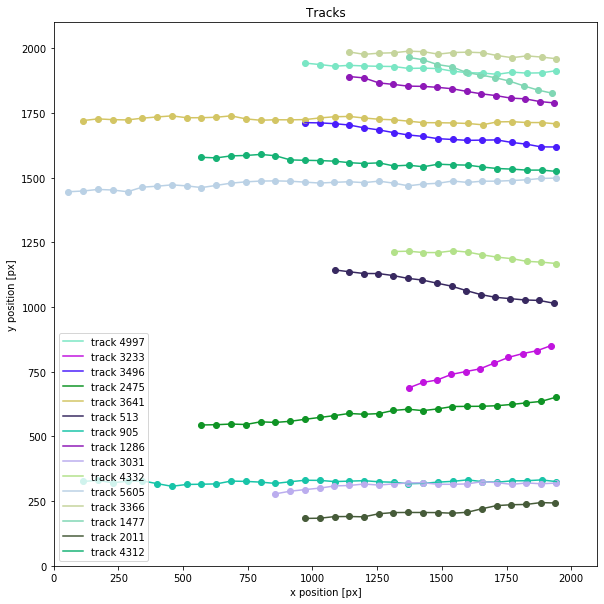

In [5]:
fake_data_set.plot_random_tracks(n=15)

In [0]:
# HParams Dashboard for Tensorboard
# -> used for hyperparameter optimization

# *Attention:* If something is changed here, then a new directory for logging is necessary
#    because HParams cannot adapt dynamically to changing HParams

HP_NUM_UNITS_FIRST_LSTM = hp.HParam('num_units_first_lstm', hp.Discrete([16]))
HP_NUM_UNITS_SECOND_LSTM = hp.HParam('num_units_second_lstm', hp.Discrete([16]))
HP_NUM_UNITS_THIRD_LSTM = hp.HParam('num_units_third_lstm', hp.Discrete([0]))
HP_NUM_UNITS_FOURTH_LSTM = hp.HParam('num_units_fourth_lstm', hp.Discrete([0]))
LSTM_LAYERS = [HP_NUM_UNITS_FIRST_LSTM, HP_NUM_UNITS_SECOND_LSTM, HP_NUM_UNITS_THIRD_LSTM, HP_NUM_UNITS_FOURTH_LSTM]

HP_NUM_UNITS_FIRST_DENSE = hp.HParam('num_units_first_dense', hp.Discrete([16]))
HP_NUM_UNITS_SECOND_DENSE = hp.HParam('num_units_second_dense', hp.Discrete([0]))
HP_NUM_UNITS_THIRD_DENSE = hp.HParam('num_units_third_dense', hp.Discrete([0]))
HP_NUM_UNITS_FOURTH_DENSE = hp.HParam('num_units_fourth_dense', hp.Discrete([0]))
DENSE_LAYERS = [HP_NUM_UNITS_FIRST_DENSE, HP_NUM_UNITS_SECOND_DENSE, HP_NUM_UNITS_THIRD_DENSE, HP_NUM_UNITS_FOURTH_DENSE]

HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam']))
HP_RNN_NAME = hp.HParam('rnn_name', hp.Discrete(['rnn'])) # 'lstm', 'rnn', 'gru'
DENSE_BATCH_NORM = hp.HParam('use_batchnorm_on_dense', hp.Discrete([True]))
LR_DECAY_AFTER_EPOCHS = hp.HParam('lr_decay_after_epochs', hp.Discrete([100]))

METRIC_MSE = 'mse'
METRIC_MAE = 'mae'

ALL_HPARAMS = [LR_DECAY_AFTER_EPOCHS, HP_RNN_NAME] + LSTM_LAYERS + DENSE_LAYERS + [DENSE_BATCH_NORM, HP_OPTIMIZER]

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
        hparams=ALL_HPARAMS,
        metrics=[
            hp.Metric(METRIC_MSE, display_name='MSE'),
            hp.Metric(METRIC_MAE, display_name='MAE'),
        ],
    )

--- Starting experiment 0/1: 2019-11-27--18-51-05
{'lr_decay_after_epochs': 100, 'rnn_name': 'rnn', 'num_units_first_lstm': 16, 'num_units_second_lstm': 16, 'num_units_third_lstm': 0, 'num_units_fourth_lstm': 0, 'num_units_first_dense': 16, 'num_units_second_dense': 0, 'num_units_third_dense': 0, 'num_units_fourth_dense': 0, 'use_batchnorm_on_dense': True, 'optimizer': 'adam'}
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_layer (Masking)      (128, 35, 2)              0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (128, 35, 16)             304       
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (128, 35, 16)             528       
_________________________________________________________________
dense_10 (Dense)             (128, 35, 16)             272       
____

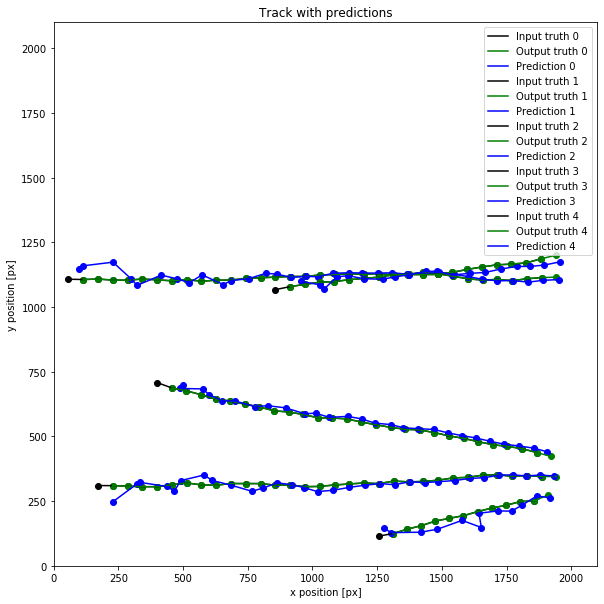

E.................................................R.

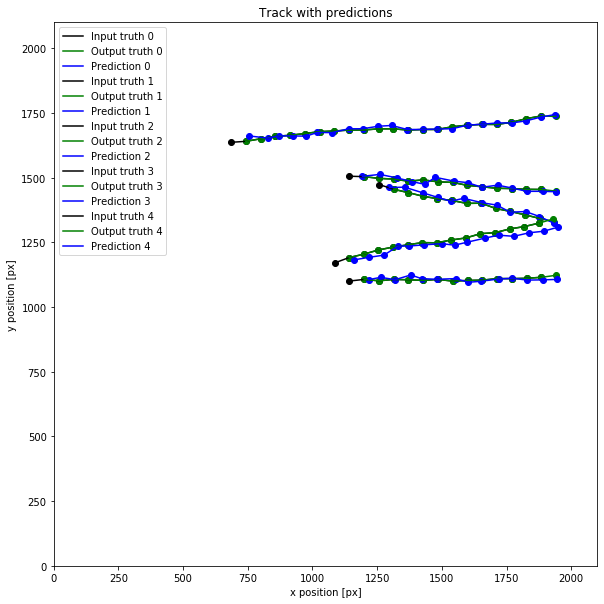

E..................................................

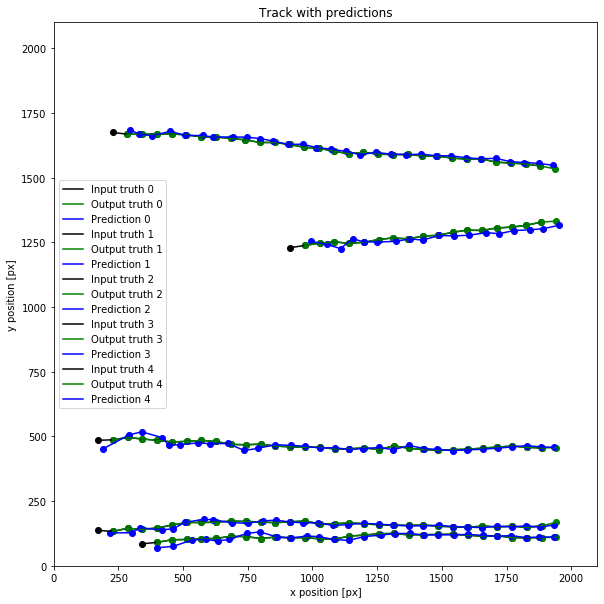

E.................................................R.

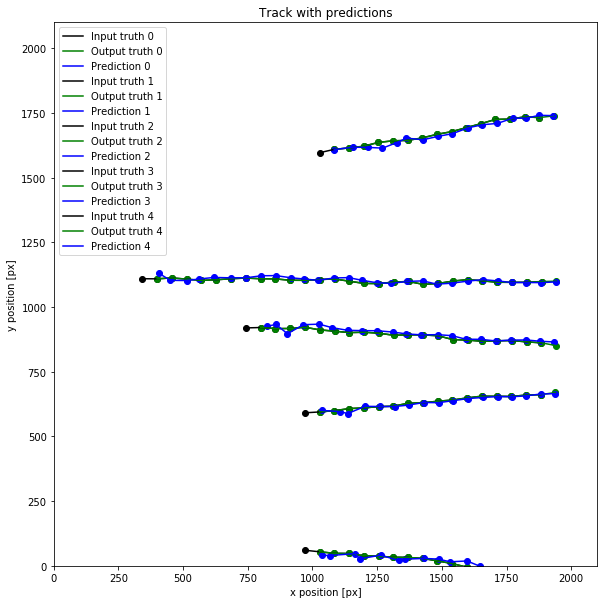

E..................................................

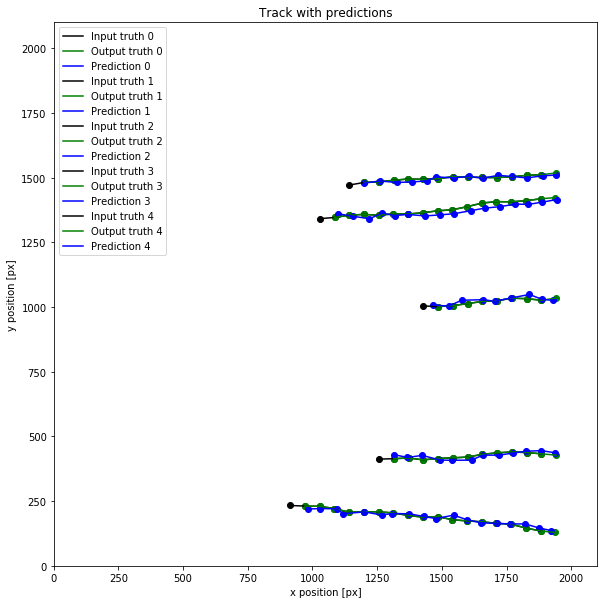

E.................................................R.

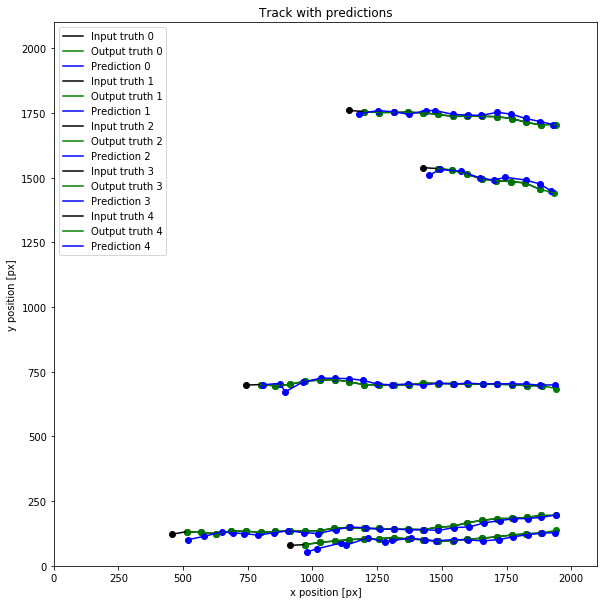

E..................................................

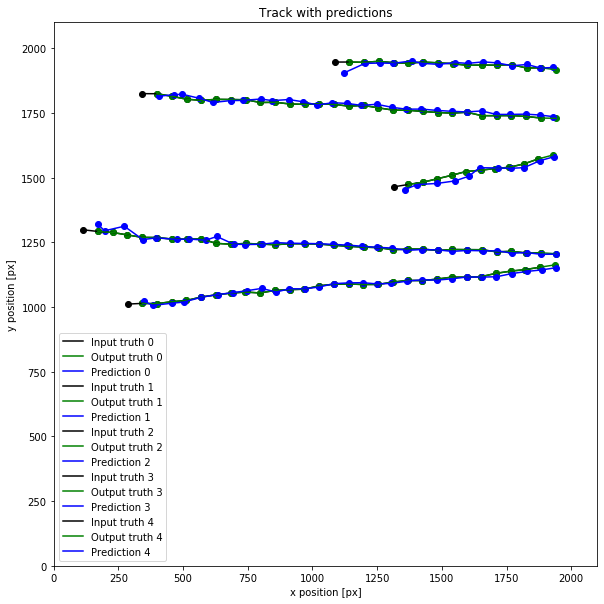

E.................................................R.

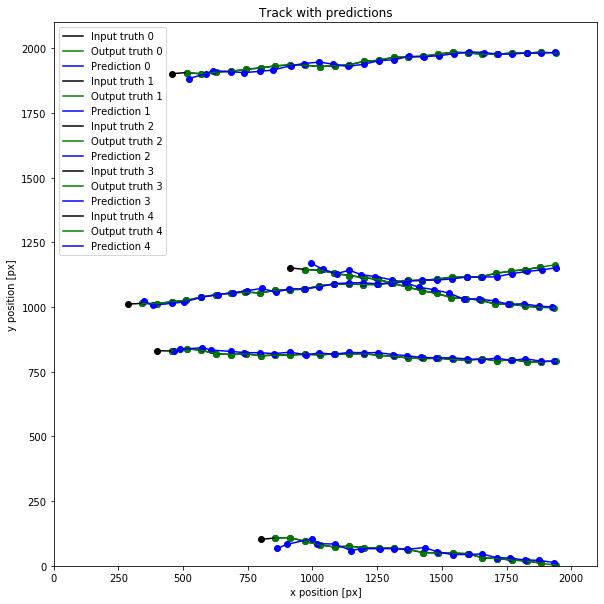

E..................................................

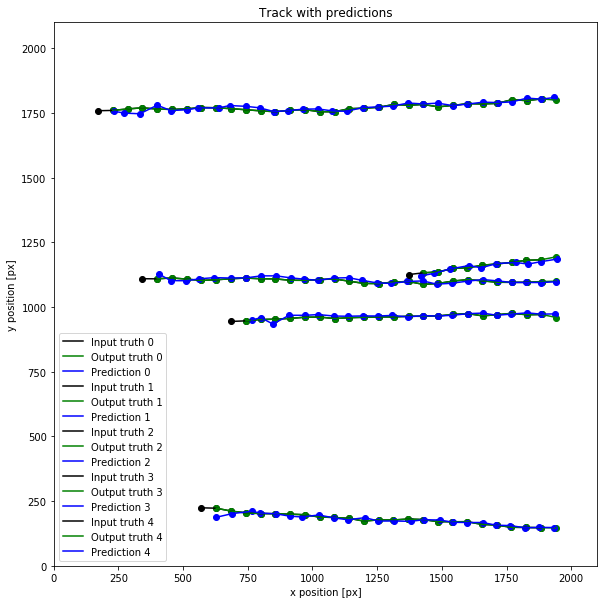

E.................................................R.

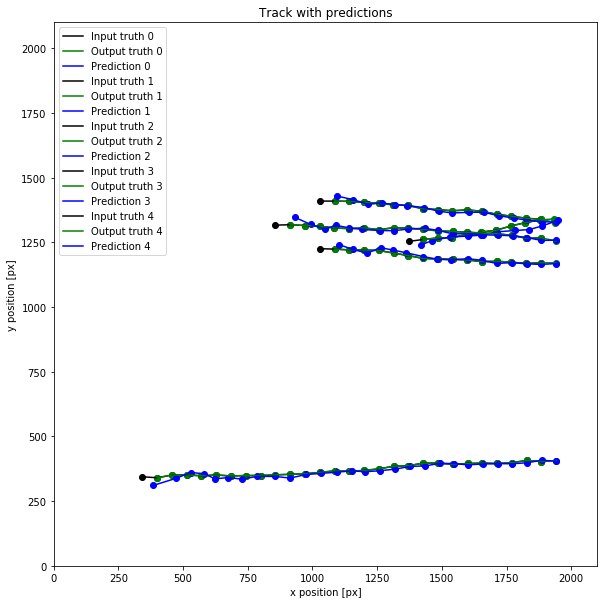

E..................................................

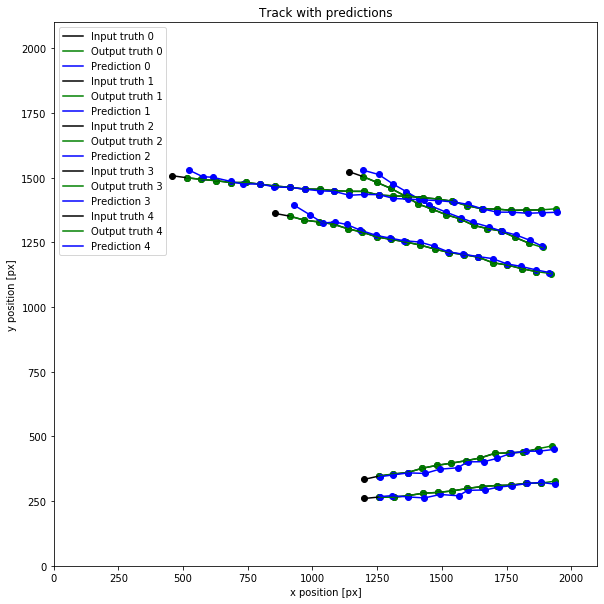

E.................................................R.

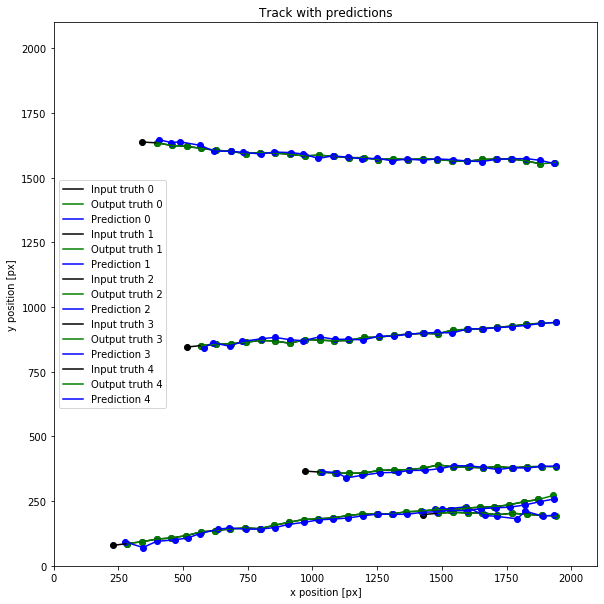

E..................................................

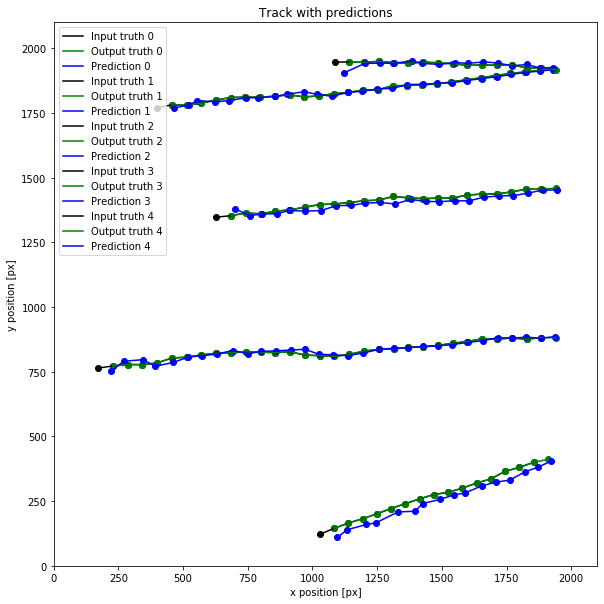

E.................................................R.

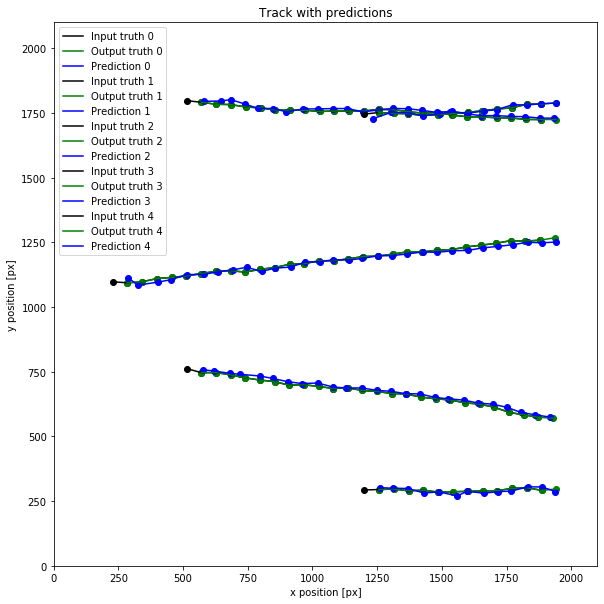

E..................................................

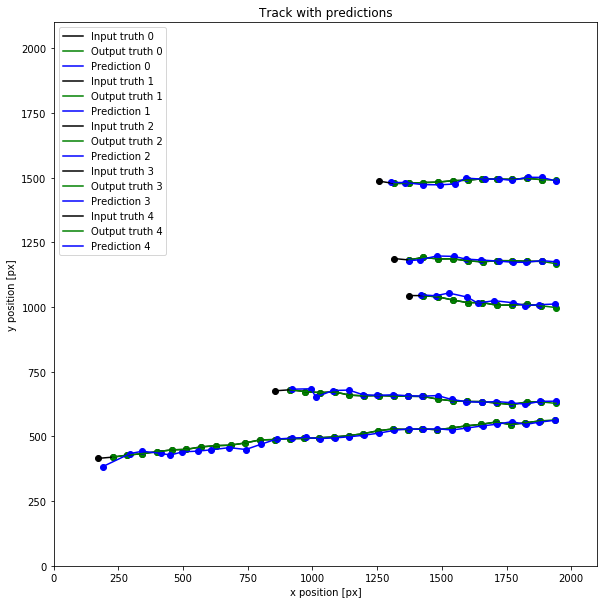

E.................................................R.

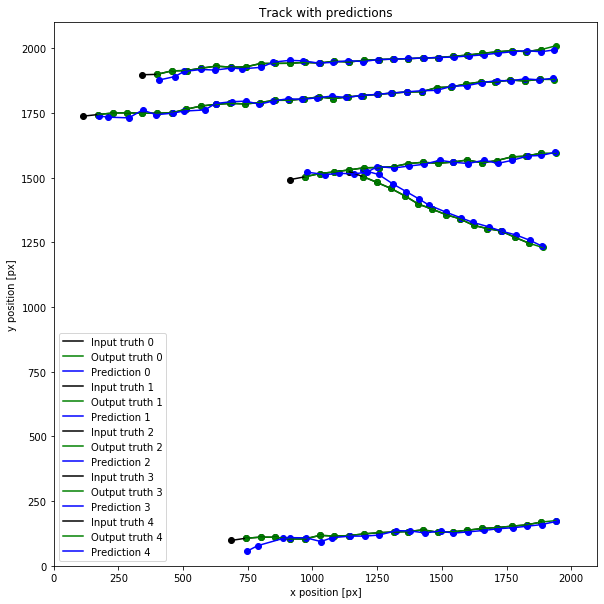

E..................................................

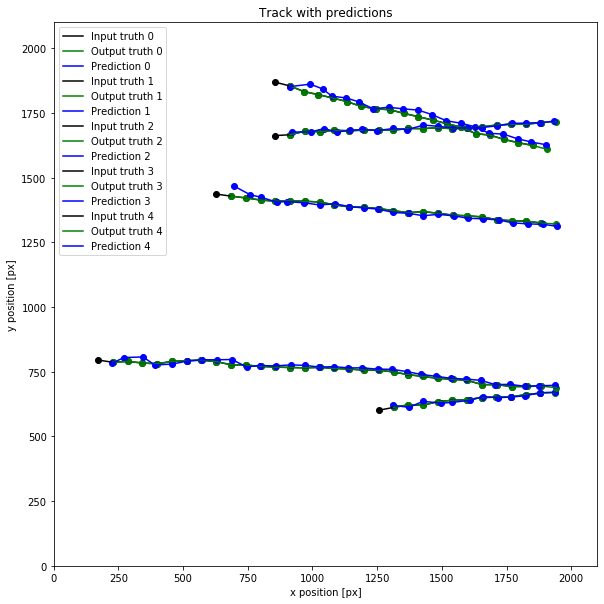

E.................................................R.

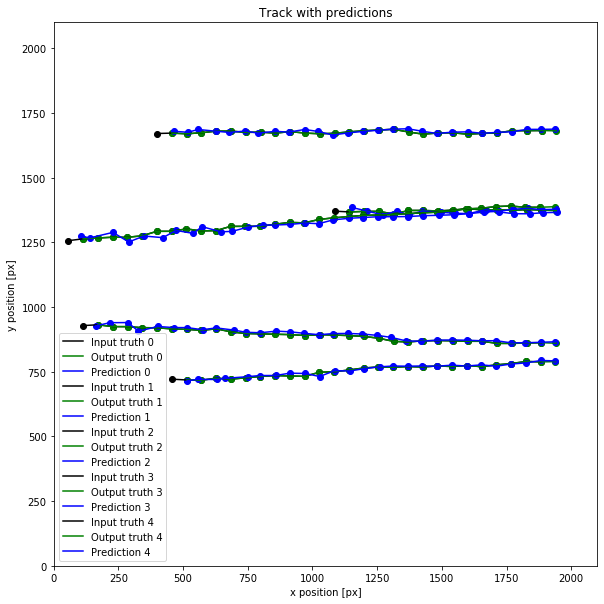

E..................................................

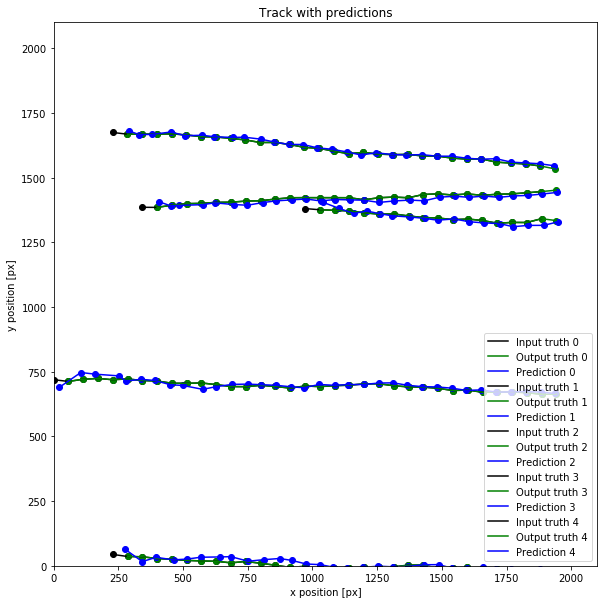

E.................................................R.

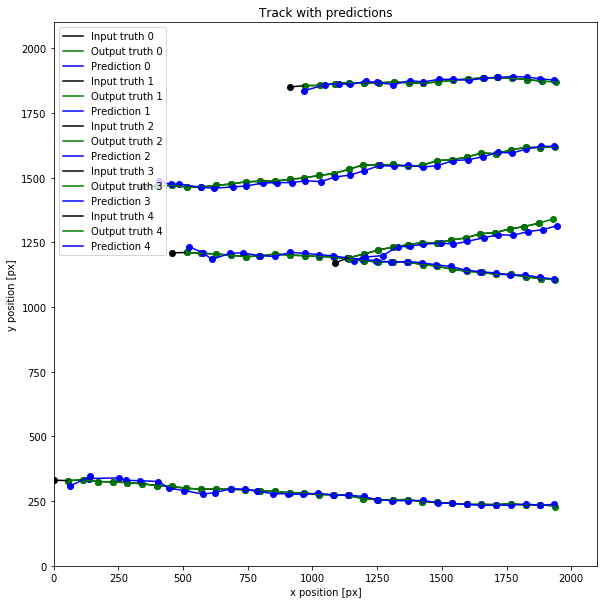

E


In [15]:
EPOCHS = 1000
EVAL_EVERY_NTH_EPOCH = 50
SAVE_WEIGHTS = False
CREATE_PLOTS = True

num_experiment = 0
total_num_experiments = len(list(itertools.product(*[param.domain.values for param in ALL_HPARAMS])))

# list containing all built models
hash_list = set()

# iterate over all possible hyperparameter combinations
for hparam_values in itertools.product(*[param.domain.values for param in ALL_HPARAMS]):
    # parameters of current run: dict(HPARAM -> value)
    hparams = dict(zip(ALL_HPARAMS, hparam_values))

    run_name = datetime.now().strftime("%Y-%m-%d--%H-%M-%S")
    print('--- Starting experiment {}/{}: {}'.format(num_experiment, total_num_experiments, run_name))
    print({h.name: hparams[h] for h in hparams})
    run_dir = 'logs/hparam_tuning/' + run_name

    step = 0
    
    rnn_model, hash_ = model.rnn_model_factory(
        num_units_first_rnn=hparams[HP_NUM_UNITS_FIRST_LSTM], 
        num_units_second_rnn=hparams[HP_NUM_UNITS_SECOND_LSTM], 
        num_units_third_rnn=hparams[HP_NUM_UNITS_THIRD_LSTM], 
        num_units_fourth_rnn=hparams[HP_NUM_UNITS_FOURTH_LSTM],

        num_units_first_dense=hparams[HP_NUM_UNITS_FIRST_DENSE], 
        num_units_second_dense=hparams[HP_NUM_UNITS_SECOND_DENSE], 
        num_units_third_dense=hparams[HP_NUM_UNITS_THIRD_DENSE], 
        num_units_fourth_dense=hparams[HP_NUM_UNITS_FOURTH_DENSE],

        rnn_model_name=hparams[HP_RNN_NAME],
        use_batchnorm_on_dense=hparams[DENSE_BATCH_NORM],
        num_time_steps=35, batch_size=128, nan_value=0, input_dim=2)
    
    print(rnn_model.summary())
    
    # The hash of a model describes its architecture. => same architectures are
    # not evaluated twice (ToDo: what about different optimizers...?)
    print(f"Hash: {hash_}")
    if hash_ in hash_list:
        print("---> Skipping model because hash already used")
        continue  
    hash_list.add(hash_)
    
    metric_lists = defaultdict(list)

    # run the training and evaluation for one model
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial

        # optimizer = 'adam'  # tf.keras.optimizers.Adam(learning_rate=hparams[HP_INITIAL_LR])
        optimizer = tf.keras.optimizers.Adam()

        # Tensorflow graphs built for the training and evaluation
        #   they are reused. We don't want to create a new graph with every epoch.
        train_step = model.train_step_generator(rnn_model, optimizer)
        train_epoch = model.train_epoch_generator(rnn_model, train_step, dataset_train, batch_size)

        calc_mse_train = model.tf_error(rnn_model, dataset_train, normalization_factor, squared=True)
        calc_mse_test = model.tf_error(rnn_model, dataset_test, normalization_factor, squared=True)
        calc_mae_train = model.tf_error(rnn_model, dataset_train, normalization_factor, squared=False)
        calc_mae_test = model.tf_error(rnn_model, dataset_test, normalization_factor, squared=False)

        for epoch in range(EPOCHS):
            # initializing the hidden state at the start of every epoch. initally hidden is None
            hidden = rnn_model.reset_states()

            # learning rate decay
            if (epoch+1) % hparams[LR_DECAY_AFTER_EPOCHS] == 0:
                old_lr = K.get_value(optimizer.lr)
                new_lr = old_lr * 0.1
                # print(f"Reducing learning rate from {old_lr} to {new_lr}.")
                print("R", end='')
                K.set_value(optimizer.lr, new_lr)

            for (batch_n, (inp, target)) in enumerate(dataset_train):
                hidden = rnn_model.reset_states()
                loss = train_step(inp, target)   
                step += batch_size

            tf.summary.scalar('training_loss', loss, step=step)
            print(".", end='')
            
            if (epoch + 1) % EVAL_EVERY_NTH_EPOCH == 0 or (epoch + 1) == EPOCHS:
                # calc metrics
                train_mse = calc_mse_train()
                test_mse = calc_mse_test()
                train_mae = calc_mae_train()
                test_mae = calc_mae_test()

                # store metrics
                metric_lists['train_mse'].append(train_mse)
                metric_lists['test_mse'].append(test_mse)
                metric_lists['train_mae'].append(train_mae)
                metric_lists['test_mae'].append(test_mae)

                # report metrics
                tf.summary.scalar('mse_train', train_mse, step=step)
                tf.summary.scalar('mse_test', test_mse, step=step)
                tf.summary.scalar('mae_train', train_mae, step=step)
                tf.summary.scalar('mae_test', test_mae, step=step)
                tf.summary.scalar('learning_rate', K.get_value(optimizer.lr), step=step)
                
                if CREATE_PLOTS:
                    fake_data_set.plot_random_predictions(rnn_model, dataset_test, display=True)
                
                print("E", end='')
                
                tf.summary.scalar(METRIC_MSE, min(metric_lists['test_mse']), step=1)
                tf.summary.scalar(METRIC_MAE, min(metric_lists['test_mae']), step=1)
                
                if SAVE_WEIGHTS:
                    rnn_model.save_weights(checkpoint_prefix.format(epoch=epoch))
    print("")
    num_experiment += 1
        
    # clear after training
    K.clear_session()  
        


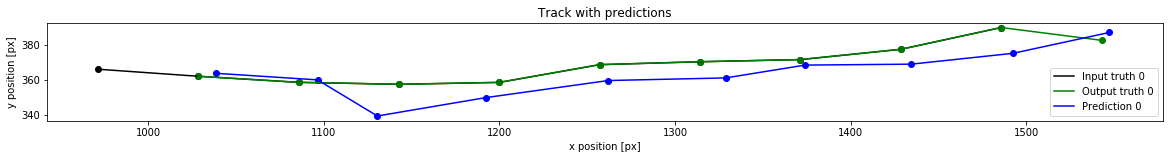

In [16]:
fake_data_set.plot_random_predictions(rnn_model, dataset_test, n=1, display=True, fit_scale_to_content=True, end_time_step=10)